# PROBLEM STATEMANT


## Mental health of India during COVID



Study the given twitter data to understand the emotions of people against Covid-19 and classify the emotion based on tweets.


### Import Libararies



In [541]:
import json

import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import os

from nltk.tokenize import regexp_tokenize
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


### Read CSV and basic Explainatory Analysis



In [519]:
data = pd.read_csv('./train/text_emotion.csv', index_col=False)

In [520]:
data.shape

(40000, 4)

In [5]:
data.columns

Index(['tweet_id', 'sentiment', 'author', 'content'], dtype='object')

In [6]:
data.sentiment.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [7]:
len(data.sentiment.unique())

13

In [8]:
data.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...



### Drop Unuseful Section, Punctuations, and lower the useful Content



In [521]:
data = data.drop('author', axis=1)
data = data.drop('tweet_id', axis=1)

In [522]:
data.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [523]:

data['content'] = data['content'].str.replace('[^\w\s]',' ');
data['content'] = data['content'].str.lower()

In [12]:
data.head()

,sentiment,content
0,empty,tiffanylue i know i was listenin to bad habi...
1,sadness,layin n bed with a headache ughhhh waitin o...
2,sadness,funeral ceremony gloomy friday
3,enthusiasm,wants to hang out with friends soon
4,neutral,dannycastillo we want to trade with someone w...


In [14]:
lbl_enc = preprocessing.LabelEncoder()
classes=lbl_enc.fit_transform(data.sentiment.values)
classes

array([ 2, 10, 10, ...,  7,  5,  7])

In [15]:
classes.shape

(40000,)

In [16]:
list(lbl_enc.classes_)

['anger',
 'boredom',
 'empty',
 'enthusiasm',
 'fun',
 'happiness',
 'hate',
 'love',
 'neutral',
 'relief',
 'sadness',
 'surprise',
 'worry']


### Prepare Data for Tokenisation



In [524]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [525]:
training_sentences,validation_sentences,training_labels, validation_labels = train_test_split(data['content'],classes, test_size=0.2);


In [526]:
training_sentences[0]

' tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part   '

In [35]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
training_sequences[0]

[8312,
 119,
 2,
 141,
 386,
 714,
 794,
 8,
 10,
 6405,
 92,
 114,
 1279,
 2822,
 581,
 3045,
 324,
 9,
 483,
 15,
 8313,
 8314]

In [36]:

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)


### Prepare the Keras model and train it



In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(13, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [38]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_5 (Dense)              (None, 13)                325       
Total params: 160,733
Trainable params: 160,733
Non-trainable params: 0
_________________________________________________________________


In [39]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/100
32000/32000 - 5s - loss: 2.1873 - accuracy: 0.2129 - val_loss: 2.1438 - val_accuracy: 0.2204
Epoch 2/100
32000/32000 - 4s - loss: 2.1381 - accuracy: 0.2442 - val_loss: 2.1404 - val_accuracy: 0.2319
Epoch 3/100
32000/32000 - 3s - loss: 2.1248 - accuracy: 0.2638 - val_loss: 2.1229 - val_accuracy: 0.2559
Epoch 4/100
32000/32000 - 4s - loss: 2.0993 - accuracy: 0.2779 - val_loss: 2.1049 - val_accuracy: 0.2745
Epoch 5/100
32000/32000 - 4s - loss: 2.0711 - accuracy: 0.2864 - val_loss: 2.0839 - val_accuracy: 0.2810
Epoch 6/100
32000/32000 - 4s - loss: 2.0218 - accuracy: 0.3030 - val_loss: 2.0328 - val_accuracy: 0.2962
Epoch 7/100
32000/32000 - 5s - loss: 1.9481 - accuracy: 0.3383 - val_loss: 1.9881 - val_accuracy: 0.3199
Epoch 8/100
32000/32000 - 4s - loss: 1.8939 - accuracy: 0.3606 - val_loss: 1.9674 - val_accuracy: 0.3284
Epoch 9/100
32000/32000 - 4s - loss: 1.8536 - accuracy: 0.3758 - val_loss: 1.9561 - val_accuracy: 0.3331
Epoch 

Epoch 78/100
32000/32000 - 5s - loss: 0.8550 - accuracy: 0.7237 - val_loss: 3.6781 - val_accuracy: 0.2755
Epoch 79/100
32000/32000 - 5s - loss: 0.8494 - accuracy: 0.7234 - val_loss: 3.7050 - val_accuracy: 0.2759
Epoch 80/100
32000/32000 - 4s - loss: 0.8433 - accuracy: 0.7279 - val_loss: 3.7365 - val_accuracy: 0.2744
Epoch 81/100
32000/32000 - 5s - loss: 0.8351 - accuracy: 0.7303 - val_loss: 3.7847 - val_accuracy: 0.2786
Epoch 82/100
32000/32000 - 5s - loss: 0.8294 - accuracy: 0.7334 - val_loss: 3.8039 - val_accuracy: 0.2772
Epoch 83/100
32000/32000 - 5s - loss: 0.8238 - accuracy: 0.7339 - val_loss: 3.8632 - val_accuracy: 0.2691
Epoch 84/100
32000/32000 - 4s - loss: 0.8177 - accuracy: 0.7368 - val_loss: 3.8973 - val_accuracy: 0.2725
Epoch 85/100
32000/32000 - 4s - loss: 0.8132 - accuracy: 0.7388 - val_loss: 3.9135 - val_accuracy: 0.2725
Epoch 86/100
32000/32000 - 4s - loss: 0.8076 - accuracy: 0.7378 - val_loss: 3.9881 - val_accuracy: 0.2581
Epoch 87/100
32000/32000 - 4s - loss: 0.8034 -


### Save the model, and other relevant file



C:\Users\SHIVAM\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\SHIVAM\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


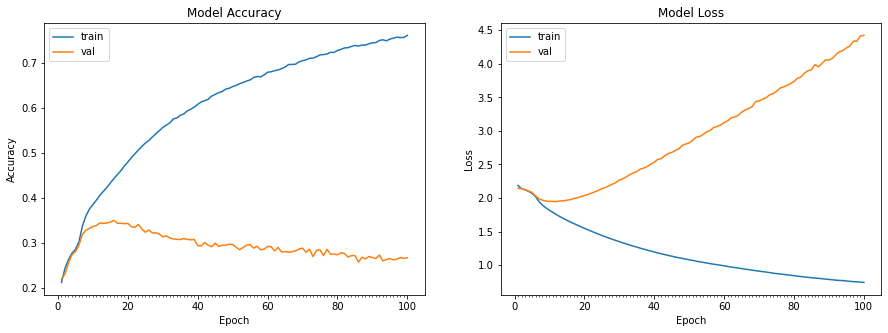

In [41]:
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(history.history['accuracy'])+1),
                history.history['accuracy'])
    axs[0].plot(range(1, len(history.history['val_accuracy'])+1),
                history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(history.history['accuracy'])+1),
                    len(history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1, len(history.history['loss'])+1),
                history.history['loss'])
    axs[1].plot(range(1, len(history.history['val_loss'])+1),
                history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(history.history['loss'])+1),
                    len(history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('./model/accuracy_and_loss_graphs.png')
    plt.show()

In [40]:
model.save_weights('./model/model.h5')

In [42]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [43]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[0])
print(lbl_enc.inverse_transform(training_labels)[0])

captainflashman wish i could eat pizza unfortunately it is forbidden here only low gi high iron stuff and lots of insulin injections ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
 tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part   
worry


In [44]:
import tsv;
out_m = tsv.TsvWriter(open("./model/meta.tsv", "w"))
out_v = tsv.TsvWriter(open("./model/vecs.tsv", "w"))
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.line(word + "\n")
    out_v.line('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


### Prepare and Load the Json files to read data


In [45]:
import os
json_text_list = []
json_files = [pos_json for pos_json in os.listdir('./data') if   pos_json.endswith('.txt')]

for index, js in enumerate(json_files):
    with open(os.path.join('./data', js)) as json_file:
        json_text_list.append(json.load(json_file))

In [ ]:
jsons_data = pd.DataFrame(columns=['text', 'location', 'date', 'time'])
index=0;

for i in range(len(json_text_list)):
    for j in range(len(json_text_list[i])):
        location = json_text_list[i][j]['location'];
        text = json_text_list[i][j]['text'];
        date = json_text_list[i][j]['date'];
        time = json_text_list[i][j]['time'];
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        jsons_data.loc[index] = [text, location, date, time];
        index+=1;

In [47]:
jsons_data.to_csv('./tweets/tweets.csv',index = False)

In [527]:
jsons_data= pd.read_csv('./tweets/tweets.csv')
jsons_data.shape

(496448, 4)

In [569]:
jsons_data.head()

,text,location,date,time
0,Curve flattening? Kenya records 48 new virus c...,IN,Sep 22,05:08:45
1,Victoria and Melbourne Covid trend map: where ...,"Erbil, Iraq",Sep 22,05:08:34
2,NSW and Sydney Covid trend map: where coronavi...,"Melbourne, Australia",Sep 22,05:08:33
3,IT’S BAKE OFF DAY! 🙌🏼\n\nWho else will be tuni...,"Melbourne, Australia",Sep 22,05:06:02
4,@DanielAndrewsMP The Liberal party bots are ou...,Fareham,Sep 22,05:05:34



### Plot the data and create a word cloud


In [570]:
tweets=jsons_data['text']

In [529]:
stop = stopwords.words('english')

tweets = tweets.str.lower()
tweets = tweets.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [530]:
tweets.head()

0    curve flattening? kenya records 48 new virus c...
1    victoria melbourne covid trend map: coronaviru...
2    nsw sydney covid trend map: coronavirus cases ...
3    it’s bake day! 🙌🏼 else tuning 8pm? recently re...
4    @danielandrewsmp liberal party bots force even...
Name: text, dtype: object

In [531]:
content = ' '.join(tweets);

In [532]:
wordcloud = WordCloud(width = 1200, height = 800, 
            min_font_size = 10).generate(content)

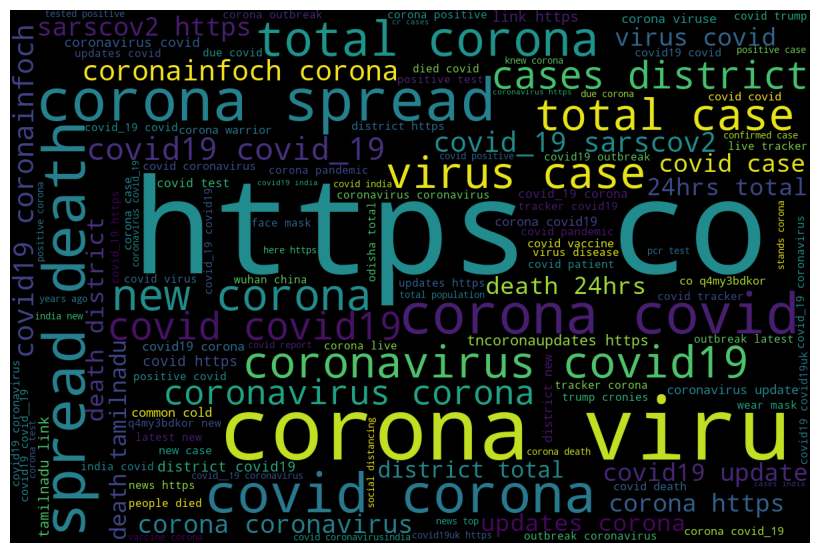

In [533]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


### Predict the Emotional data and  Plot Relevant graphs


In [572]:

training_sequences = tokenizer.texts_to_sequences(jsons_data['text'])
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(13, activation='softmax')
])
model.load_weights('./model/model.h5')

In [573]:
prediction= model.predict(training_padded)

In [574]:
prediction.shape

(496448, 13)

In [575]:
rowmax= prediction.argmax(axis=1)

In [576]:
emotions = lbl_enc.inverse_transform(rowmax)

In [577]:
jsons_data['emotions']= emotions;

In [578]:
jsons_data.shape

(496448, 5)

In [579]:
jsons_data.head()

,text,location,date,time,emotions
0,Curve flattening? Kenya records 48 new virus c...,IN,Sep 22,05:08:45,worry
1,Victoria and Melbourne Covid trend map: where ...,"Erbil, Iraq",Sep 22,05:08:34,worry
2,NSW and Sydney Covid trend map: where coronavi...,"Melbourne, Australia",Sep 22,05:08:33,worry
3,IT’S BAKE OFF DAY! 🙌🏼\n\nWho else will be tuni...,"Melbourne, Australia",Sep 22,05:06:02,surprise
4,@DanielAndrewsMP The Liberal party bots are ou...,Fareham,Sep 22,05:05:34,hate


In [580]:
labels = lbl_enc.classes_

In [593]:
sizes = jsons_data['emotions'].value_counts()
labels=sizes.index;
y_pos = np.arange(len(labels))
print(sizes)

worry         212541
neutral       133096
hate           28991
sadness        27667
surprise       26232
happiness      17901
fun            15262
love           11800
relief         10380
empty           6777
enthusiasm      3797
boredom         1765
anger            239
Name: emotions, dtype: int64


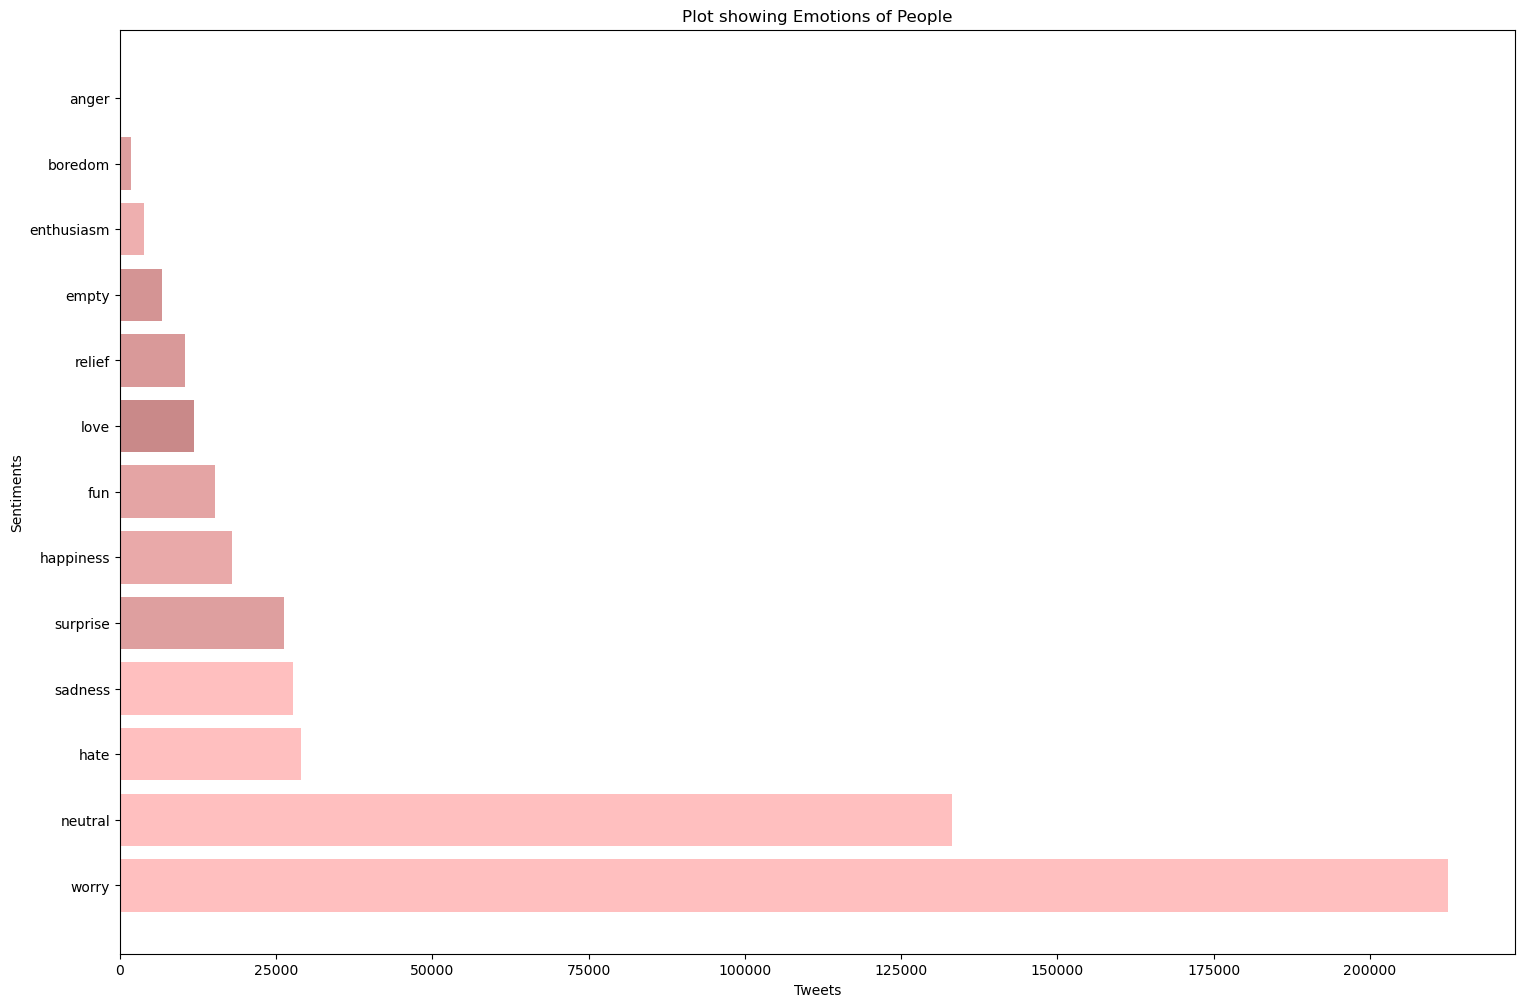

In [440]:
data = [2,2,2,2,8, 6, 7, 12, 9, 10, 5, 8, 14]
# Colorize the graph based on likeability:
likeability_scores = np.array(data)
data_normalizer = mpl.colors.Normalize()
color_map = mpl.colors.LinearSegmentedColormap(
    "my_map",
    {"red": [(0, 1.0, 1.0),(1.0, .5, .5)],"green": [(0, 0.5, 0.5),(1.0, 0, 0)],"blue": [(0, 0.50, 0.5),(1.0, 0, 0)]})
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(18,12))

ax.barh(y_pos, sizes, align='center', alpha=0.5, color= color_map(data_normalizer(likeability_scores)))
ax.set_yticks(y_pos)
ax.set_xlabel('Tweets')
ax.set_ylabel('Sentiments')

ax.set_title('Plot showing Emotions of People')
ax.set_yticklabels(labels)
plt.show()

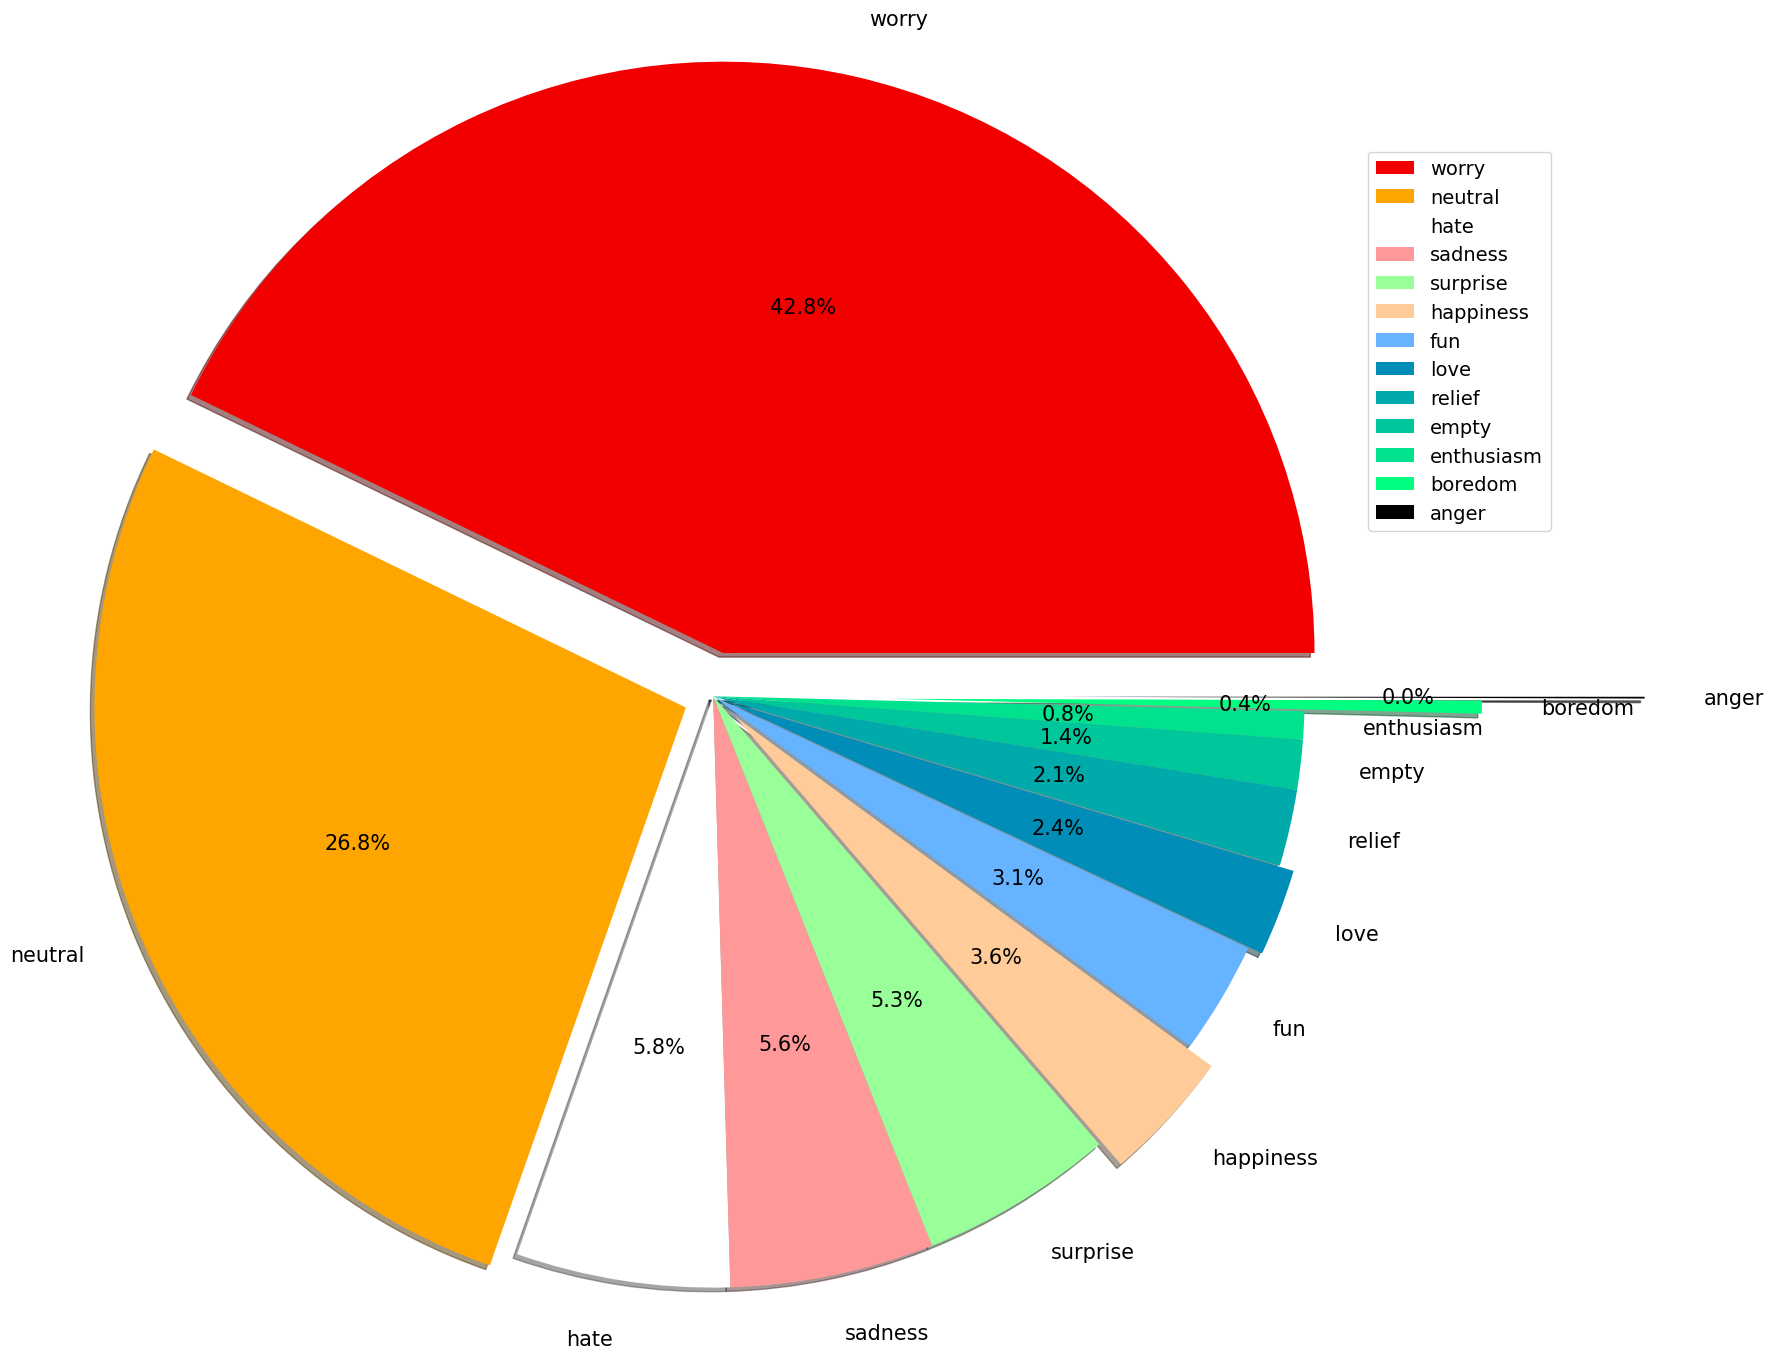

In [566]:
plt.axis('equal')
explode = (0.3, 0.2, 0,0,0,0.2,0,0.1,0.0,0.0,0.0,1.2,2.3)
colors = ['#F20000','#FFA500','#FFFFFF','#ff9999','#99ff99','#ffcc99','#66b3ff','#008DB8','#00AAAA','#00C69C','#00E28E','#00FF80','#000000']
sizes.plot(kind='pie', fontsize=15,colors=colors,explode=explode, radius=4, label='', autopct='%1.1f%%',shadow=True)
plt.legend(labels=labels, bbox_to_anchor=(1.8, 2),fontsize=14)

plt.show()


### Get information  regarding location of Tweets and  Plot Relevant graphs



In [581]:
jsons_data['location'].nunique(dropna = True)

3439

In [582]:
locations=jsons_data.groupby(jsons_data['location']).agg(count =('location',pd.Series.count))

locations.head()

,count
location,
,50
,28
الرياض,2
WorldWide,34
(he/him) && (she/her),28


In [587]:
locations=locations.sort_values(by="count", ascending=False)

locations=locations.head(15)
locations['location']=locations.index
locations.head()

,count,location
location,,
India,33568,India
Switzerland,14844,Switzerland
United Kingdom,5801,United Kingdom
"Punjab, India",4729,"Punjab, India"
United States,4104,United States


In [596]:
locations.head()

,count,location
location,,
India,33568,India
Switzerland,14844,Switzerland
United Kingdom,5801,United Kingdom
"Punjab, India",4729,"Punjab, India"
United States,4104,United States


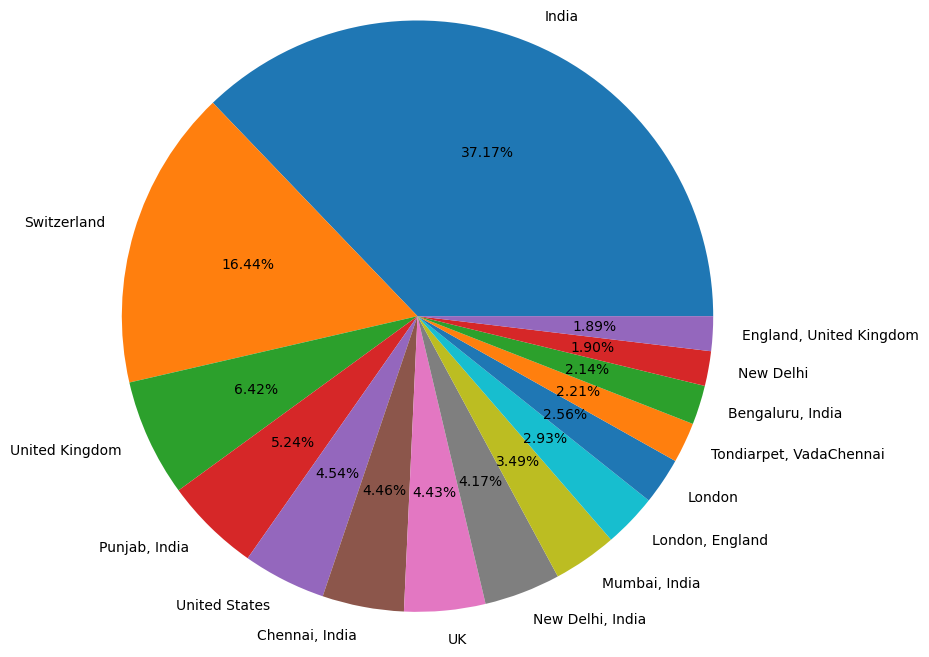

In [589]:
locations['count'].plot(kind='pie', autopct='%.2f%%', radius=2,subplots=True, label='');


### Get information  regarding date of Tweets and  Plot Relevant graphs


In [453]:
min(jsons_data['date'])

'Sep 13'

In [76]:
max(jsons_data['date'])

'Sep 22'

In [77]:
dates=jsons_data.groupby(jsons_data['date']).agg(count =('date',pd.Series.count))

In [78]:
dates

,count
date,
Sep 13,14848
Sep 14,40580
Sep 15,42086
Sep 16,43735
Sep 17,44676
Sep 18,53779
Sep 19,60274
Sep 20,65575
Sep 21,86558


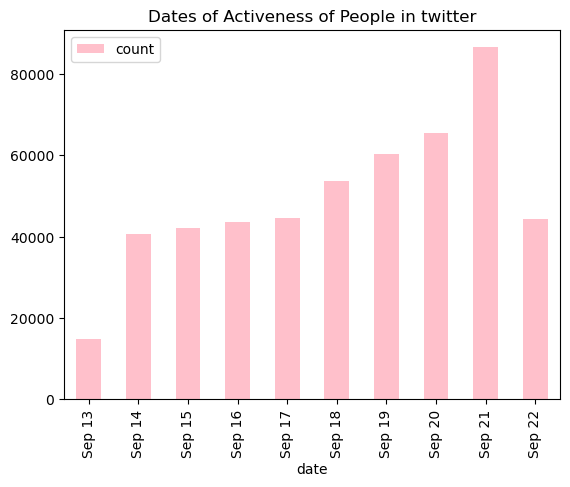

In [594]:
dates.plot.bar(title='Dates of Activeness of People in twitter', color='pink');


### Get information  regarding time of Tweets and  Plot Relevant graphs

In [534]:
hour =pd.to_datetime(jsons_data['time'], format='%H:%M:%S').dt.hour


In [535]:
hour.shape

(496448,)

In [257]:
hours=hour.to_frame()

In [259]:
hours=jsons_data.groupby(hours['time']).agg(count =('time',pd.Series.count)

In [267]:
hours.head(24)

,count,hour
0,12249,0
1,11812,1
2,11163,2
3,14585,3
4,19531,4
5,18206,5
6,21190,6
7,23564,7
8,21106,8
9,20128,9


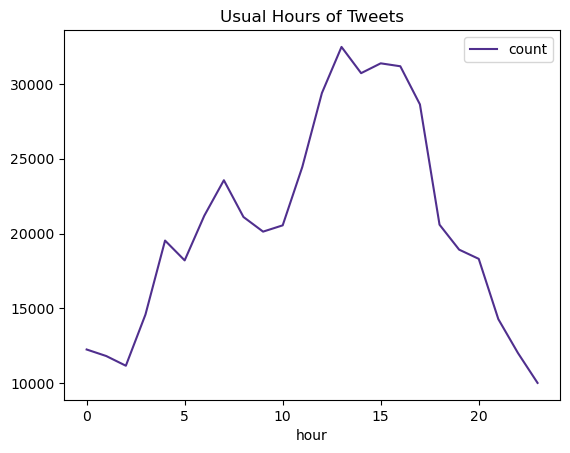

In [595]:
hours.plot(x='hour',y='count', title='Usual Hours of Tweets', c='#502f8e');

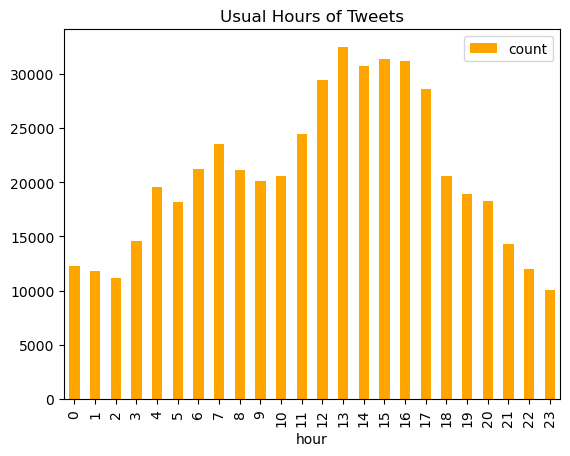

In [442]:
hours.plot.bar(x='hour',y='count', title='Usual Hours of Tweets', color='orange');


### Plot Relevant graphs With respect to Emotions of People


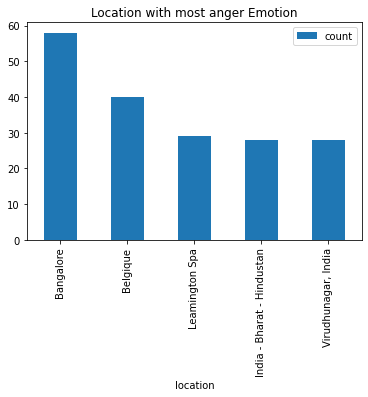

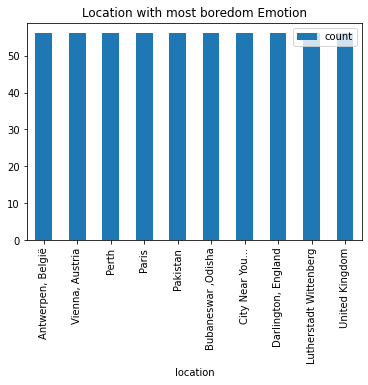

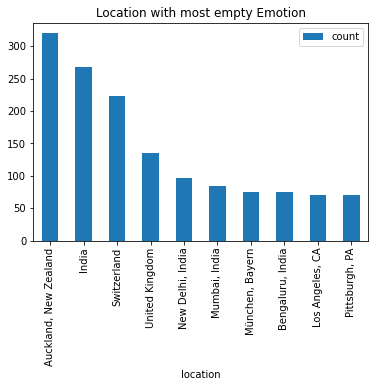

F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning:

Glyph 55356 missing from current font.

F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning:

Glyph 56824 missing from current font.

F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning:

Glyph 56827 missing from current font.

F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning:

Glyph 55356 missing from current font.

F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning:

Glyph 56824 missing from current font.

F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning:

Glyph 56827 missing from current font.



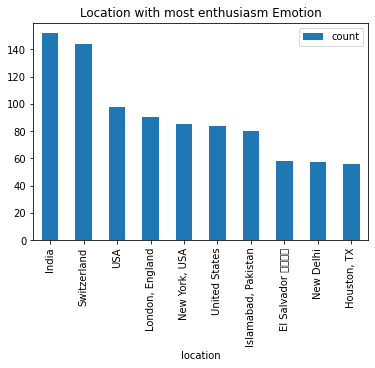

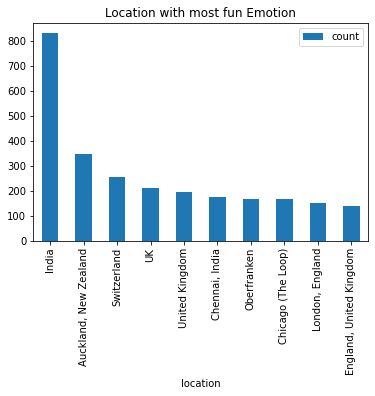

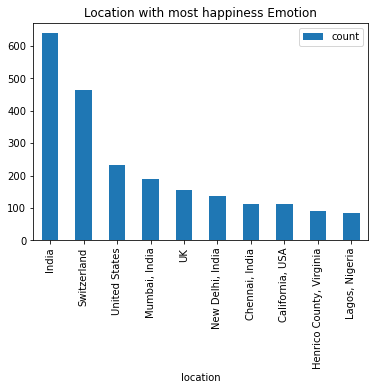

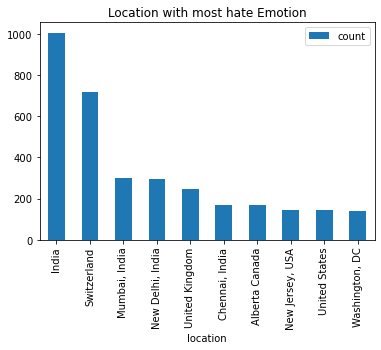

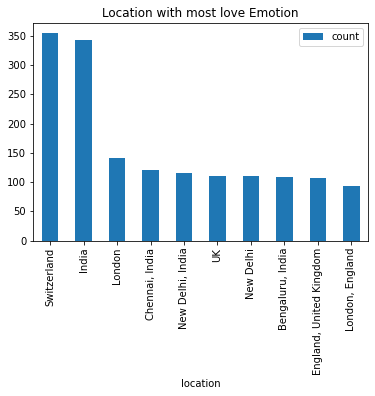

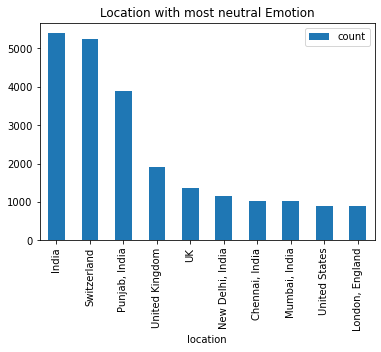

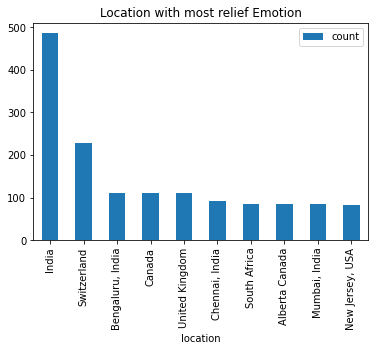

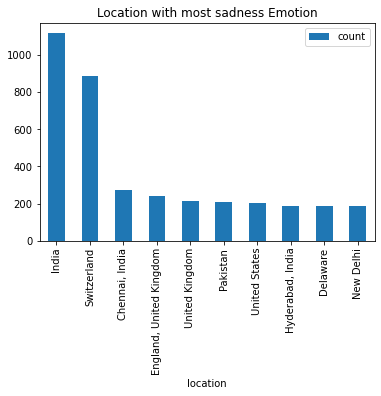

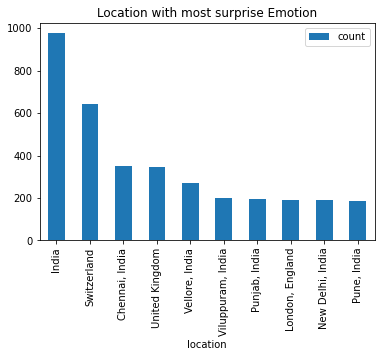

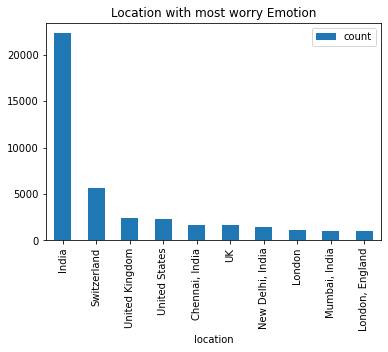

In [281]:
for i in lbl_enc.classes_:
    globals()['%s' % i] = jsons_data[jsons_data['emotions'] == i]
    globals()['locations_of_%s' % i] = globals()['%s' % i].groupby(globals()['%s' % i]['location']).agg(count =('location',pd.Series.count))
    globals()['locations_of_%s' % i] = globals()['locations_of_%s' % i].sort_values(by="count", ascending=False).head(10)
    graph_title = 'Location with most %s Emotion' % i
    globals()['locations_of_%s' % i].plot.bar(title= graph_title);

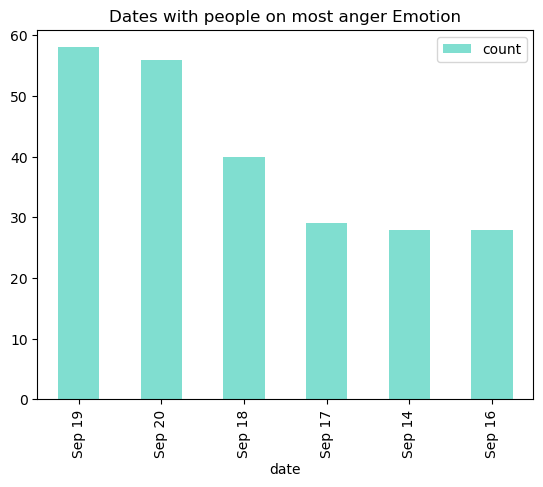

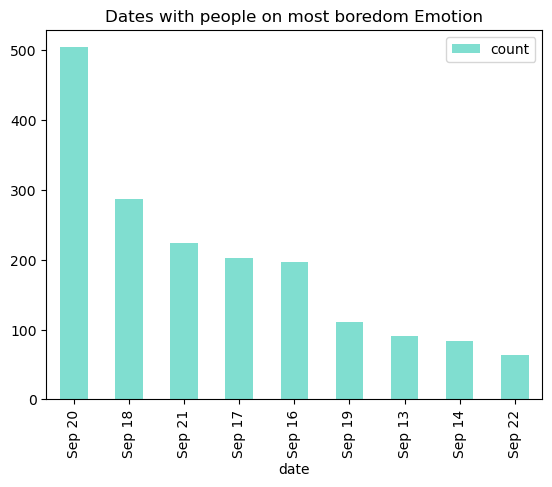

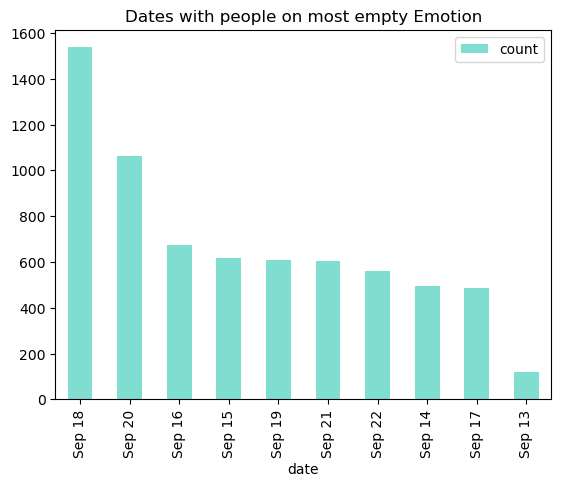

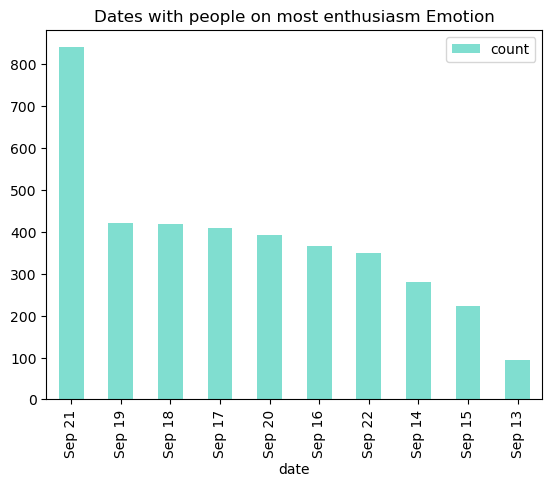

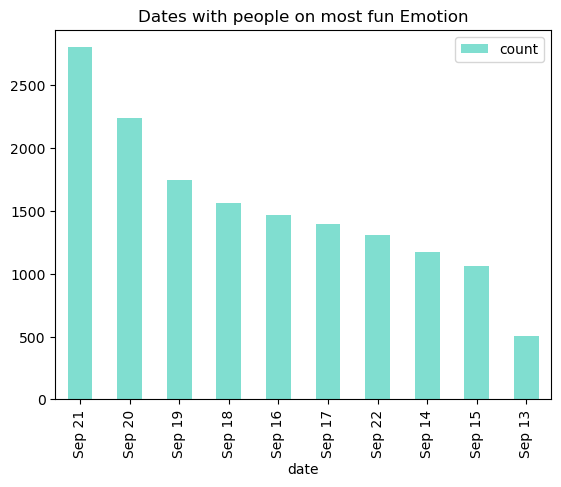

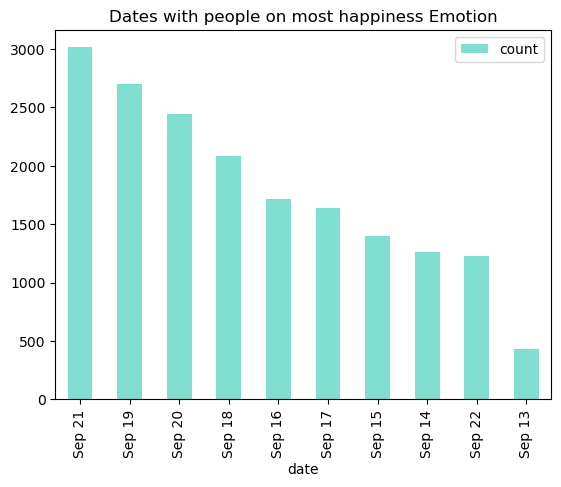

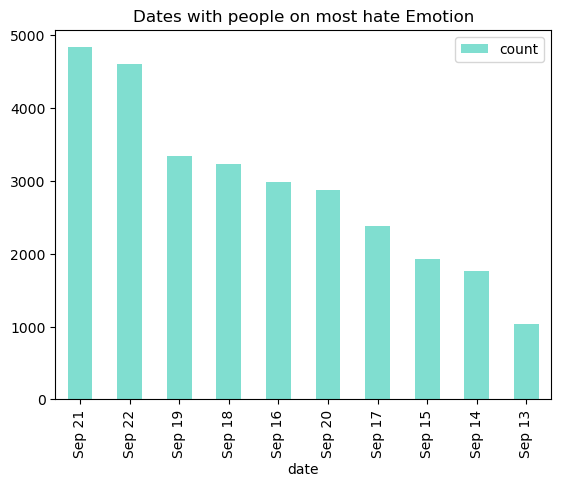

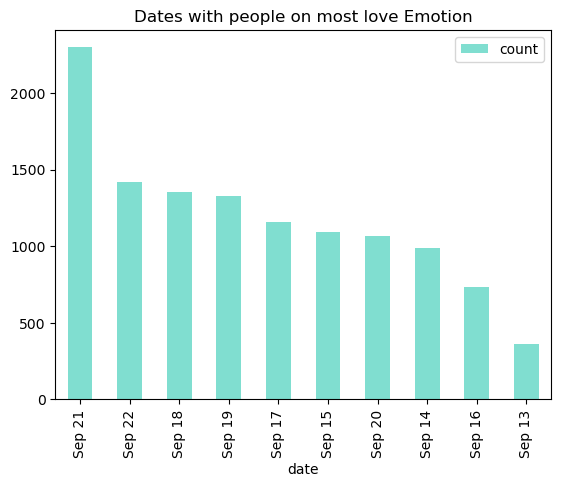

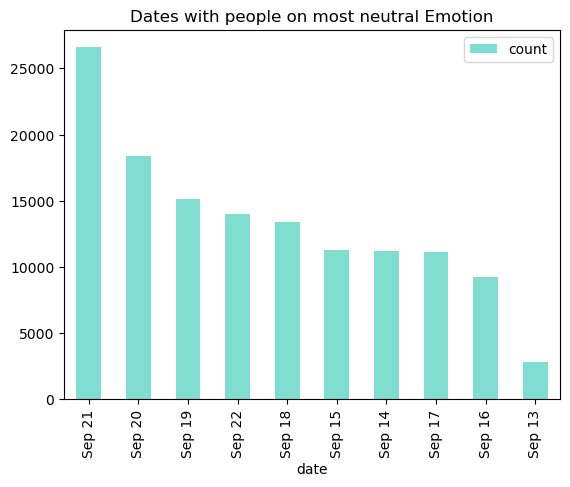

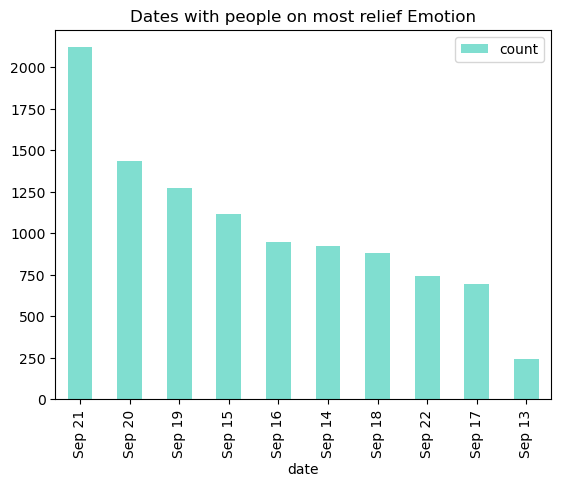

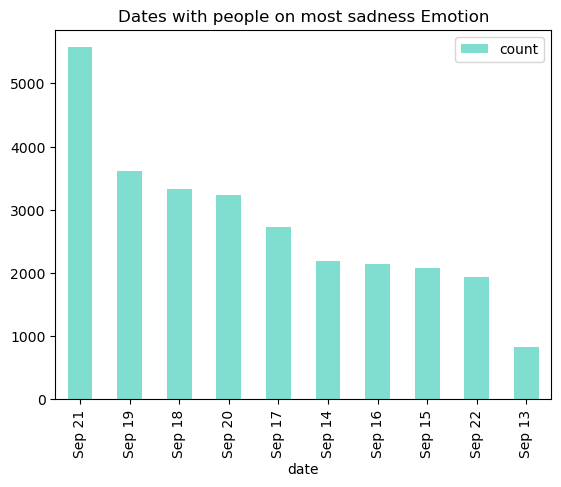

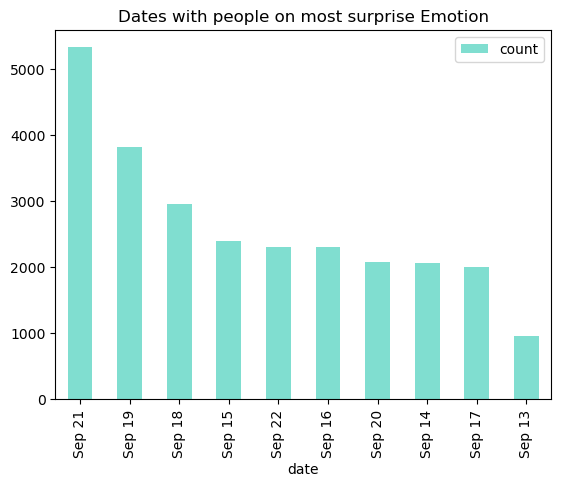

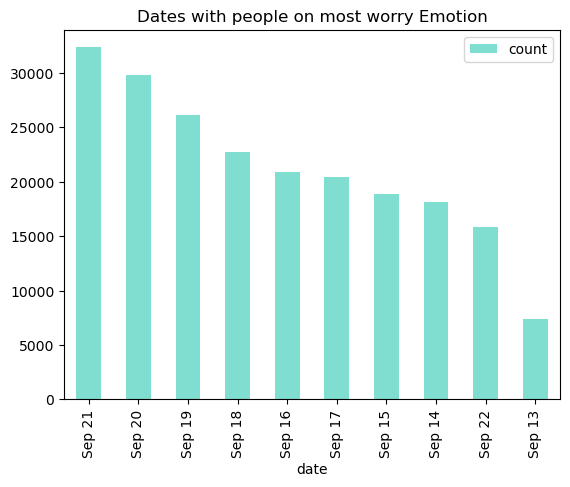

In [451]:
for i in lbl_enc.classes_:
    globals()['%s' % i] = jsons_data[jsons_data['emotions'] == i]
    globals()['dates_of_%s' % i] = globals()['%s' % i].groupby(globals()['%s' % i]['date']).agg(count =('date',pd.Series.count))
    globals()['dates_of_%s' % i] = globals()['dates_of_%s' % i].sort_values(by="count", ascending=False).head(10)
    graph_title = 'Dates with people on most %s Emotion' % i
    globals()['dates_of_%s' % i].plot.bar(title= graph_title, color='#80DED0');


### Get information regarding trending Hashtags and plot its Trending Graphs



In [536]:
def make_frequency_list(wordlist):
    freq = dict()
    
    for word in wordlist:
        if word in freq.keys():
            freq[word] += 1
        else:
            freq[word] = 1
    return freq
hashtag_pattern = r'#\w+'
hashtags = regexp_tokenize(" ".join(jsons_data['text']), hashtag_pattern)
print("Total number of hashtags in the tweets:", len(hashtags))
hashtag_freq = make_frequency_list(hashtags)
print("Total number of Unique tags:", len(hashtag_freq.keys()))

Total number of hashtags in the tweets: 1360194
Total number of Unique tags: 7675


In [537]:
raw = ' '.join(tweets)
tags = [re.sub(r"(\W+)$", "", j[1:]) for j in [i for i in raw.split() if i.startswith("#")]]
df = pd.DataFrame({"hashtag": tags})

In [538]:
print(df['hashtag'].value_counts().head(20))

corona                 125391
covid19                 96883
coronavirus             91962
covid                   69214
covid_19                67313
covid__19               24030
sarscov2                15782
coronainfoch            14828
tncoronaupdates         14017
pandemic                10374
india                   10268
coronavirusindia         9397
coronavirusupdates       7864
staysafe                 7661
coronaviruspandemic      7260
covidー19                 7129
covid19india             6990
covid19uk                6644
lockdown                 6513
virus                    5630
Name: hashtag, dtype: int64


F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning:

Glyph 12540 missing from current font.

F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning:

Glyph 12540 missing from current font.



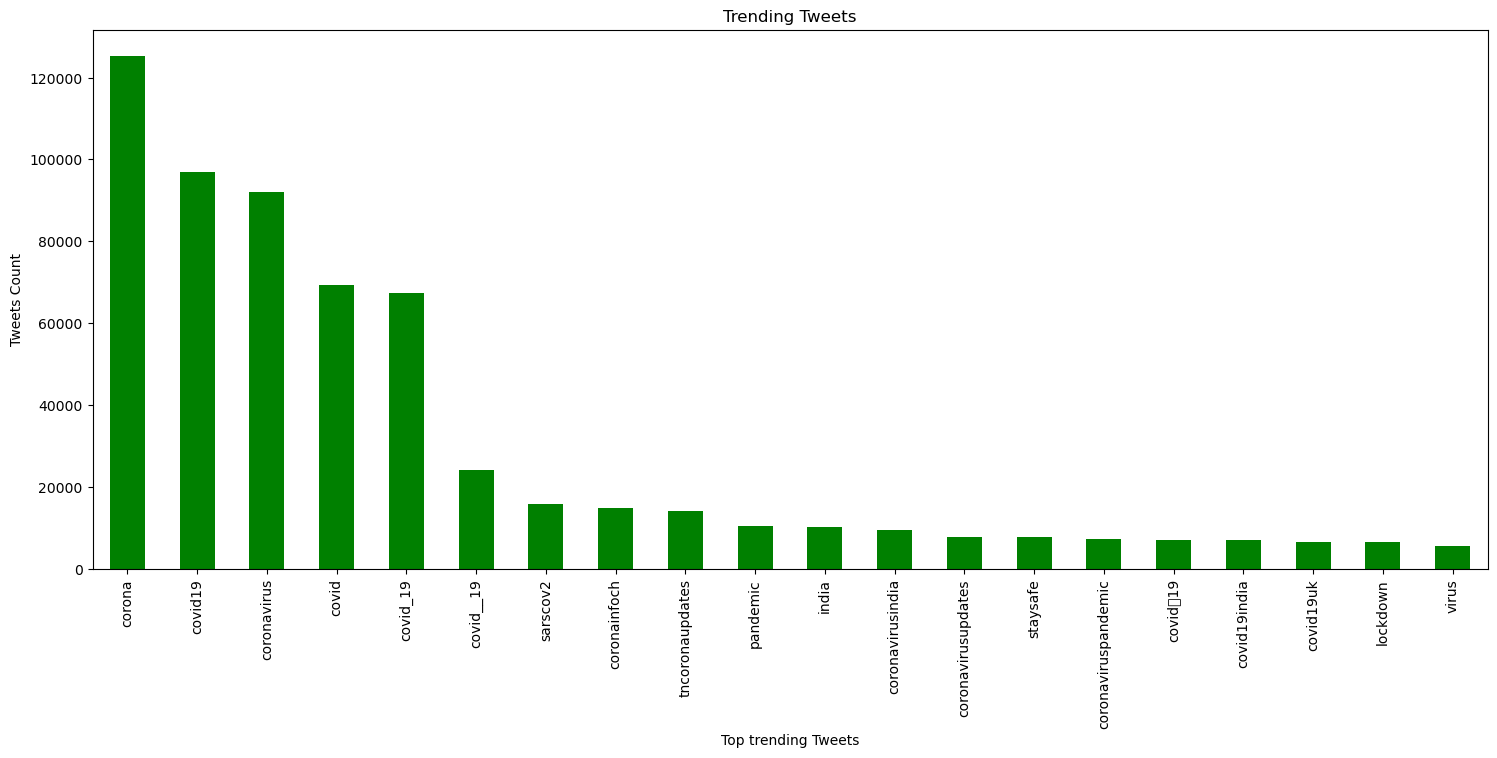

In [539]:
fig, ax = plt.subplots()
plt.xlabel('Top trending Tweets')
plt.ylabel('Tweets Count')
plt.title('Trending Tweets')
df['hashtag'].value_counts().head(20).plot(ax=ax, kind='bar',figsize=(18,7), color='green');

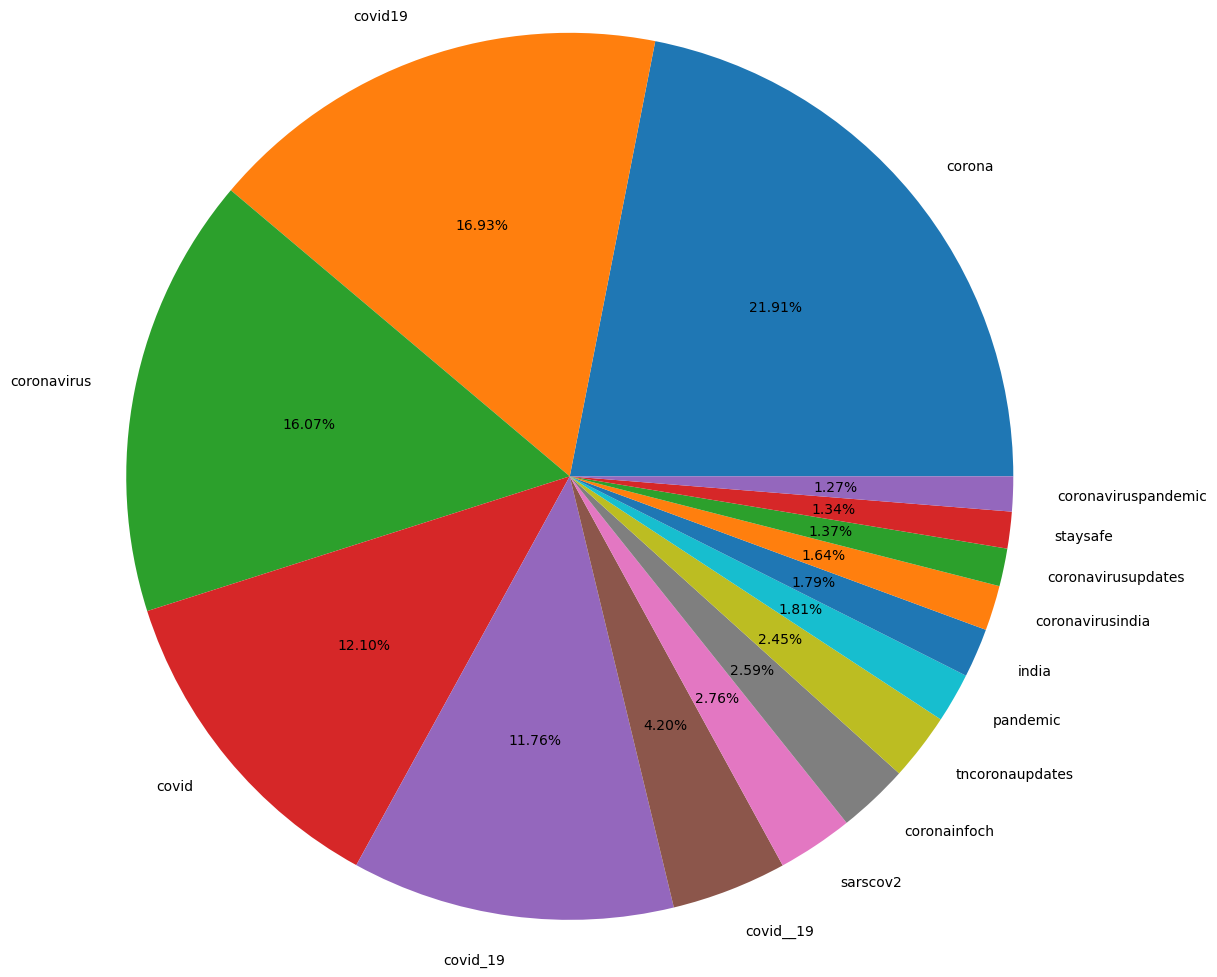

In [540]:
df['hashtag'].value_counts().head(15).plot(kind='pie', autopct='%.2f%%', radius=3, label='');

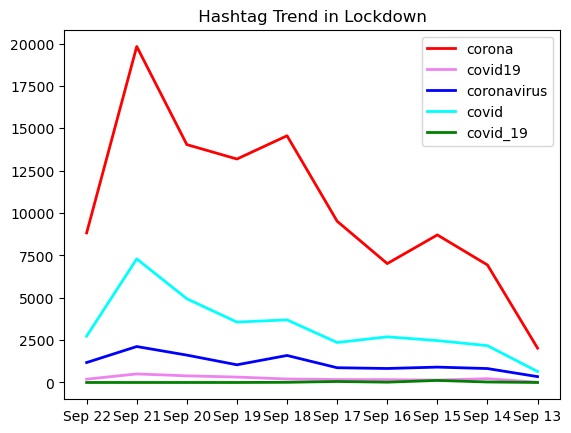

In [592]:
legend=[];
colors=['red', 'violet','blue', 'cyan','green']
for color,i in zip(colors,df['hashtag'].value_counts().head().index.values):
    y=[];
    x=[];
    for j in jsons_data['date'].unique():
        globals()['%s' % i] = jsons_data[jsons_data['date'] == j]
        hashtag_pattern = r'#'+i+'\w+'
        hashtags = len(regexp_tokenize(" ".join(globals()['%s' % i]['text']), hashtag_pattern))
        y.append(hashtags);
        x.append(j);
    plt.plot(x, y, color=color, linewidth=2)
    
plt.title(' Hashtag Trend in Lockdown ')
plt.legend(labels=df['hashtag'].value_counts().head().index.values)
plt.show()
       

# THE END